In [4]:
from pathlib import Path

import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord

PROTEIN_CLS = "RAS"
REF_PDB_ID = "4OBE_A"
WD = Path(f"../../data/{PROTEIN_CLS}/generated/")

In [5]:
records = []
fm_records, sm_records = [], []

for fasta in sorted((WD / "Q").glob("*.fasta"), key=lambda x: (x.stem.split('_')[0], int(x.stem.split('_')[1]))):
    with open(fasta, "r") as f:
        record = next(SeqIO.parse(f, "fasta"))
        record = SeqRecord(record.seq, id=record.id, description="")
        records.append(record)
        if record.id.startswith("SM"):
            sm_records.append(record)
        elif record.id.startswith("FM"):
            fm_records.append(record)

# Ref. exp. derived seq
df = pd.read_csv(rf"../../data/{PROTEIN_CLS}.csv")
records.append(
    SeqRecord(df[df["Entry ID"] == REF_PDB_ID.split("_")[0]].iloc[0]["Sequence"], id=REF_PDB_ID, description=""))

SEQS_FASTA = WD / "C/all.fasta"
FMSQ_FASTA = WD / "C/fm.fasta"
SMSQ_FASTA = WD / "C/sm.fasta"
with open(SEQS_FASTA, "w") as f:
    SeqIO.write(records, f, "fasta")
with open(FMSQ_FASTA, "w") as f:
    SeqIO.write(fm_records, f, "fasta")
with open(SMSQ_FASTA, "w") as f:
    SeqIO.write(sm_records, f, "fasta")

/home/tz365/miniconda3/envs/proteval/lib/python3.10/site-packages/Bio/SeqRecord.py:228: BiopythonDeprecationWarning: Using a string as the sequence is deprecated and will raise a TypeError in future. It has been converted to a Seq object.
  warnings.warn(


In [6]:
ALN_FASTA = WD / "C/aln.fasta"
!clustalo -i {SEQS_FASTA} -o {ALN_FASTA} --outfmt=fa

FATAL: Cowardly refusing to overwrite already existing file '../../data/RAS/generated/C/aln.fasta'. Use --force to force overwriting.


In [7]:
FM_DISTMAT = WD / "C/distmat.fm.txt"
SM_DISTMAT = WD / "C/distmat.sm.txt"
!clustalo -i {FMSQ_FASTA} --distmat-out={FM_DISTMAT} --full
!clustalo -i {SMSQ_FASTA} --distmat-out={SM_DISTMAT} --full

FATAL: Cowardly refusing to overwrite already existing file '../../data/RAS/generated/C/distmat.fm.txt'. Use --force to force overwriting.
FATAL: Cowardly refusing to overwrite already existing file '../../data/RAS/generated/C/distmat.sm.txt'. Use --force to force overwriting.


In [8]:
fm_levels, fm_length = [], []
sm_levels, sm_length = [], []
rf_levels = []

for record in SeqIO.parse(ALN_FASTA, "fasta"):
    level = []
    consurf = pd.read_csv(WD / f"C/{record.id}_consurf_grades.csv")

    res_idx = 0
    for idx, res in enumerate(record.seq):
        if res == "-":
            res_lvl = 0
        else:
            assert res == consurf.iloc[res_idx]["SEQ"]
            res_lvl = consurf.iloc[res_idx]["COLOR"]
            res_idx += 1
        level.append(res_lvl)

    if record.id.startswith("SM"):
        sm_levels.append(level)
        sm_length.append(res_idx)
    elif record.id.startswith("FM"):
        fm_levels.append(level)
        fm_length.append(res_idx)
    else:
        rf_levels = level

fm_levels = [item for _, item in sorted(zip(fm_length, fm_levels), key=lambda x: x[0])]
sm_levels = [item for _, item in sorted(zip(sm_length, sm_levels), key=lambda x: x[0], reverse=True)]

In [9]:
def average_pairwise_distance(distmat_f):
    with open(distmat_f, 'r') as f:
        lines = f.readlines()

    int(lines[0].strip())
    matrix = []
    for line in lines[1:]:
        parts = line.split()
        if not parts:
            continue
        row = list(map(float, parts[1:]))
        matrix.append(row)
    matrix = np.array(matrix)
    
    n = matrix.shape[0]
    total = 0.0
    count = 0
    for i in range(n):
        for j in range(i + 1, n):
            total += matrix[i][j]
            count += 1
    return total / count

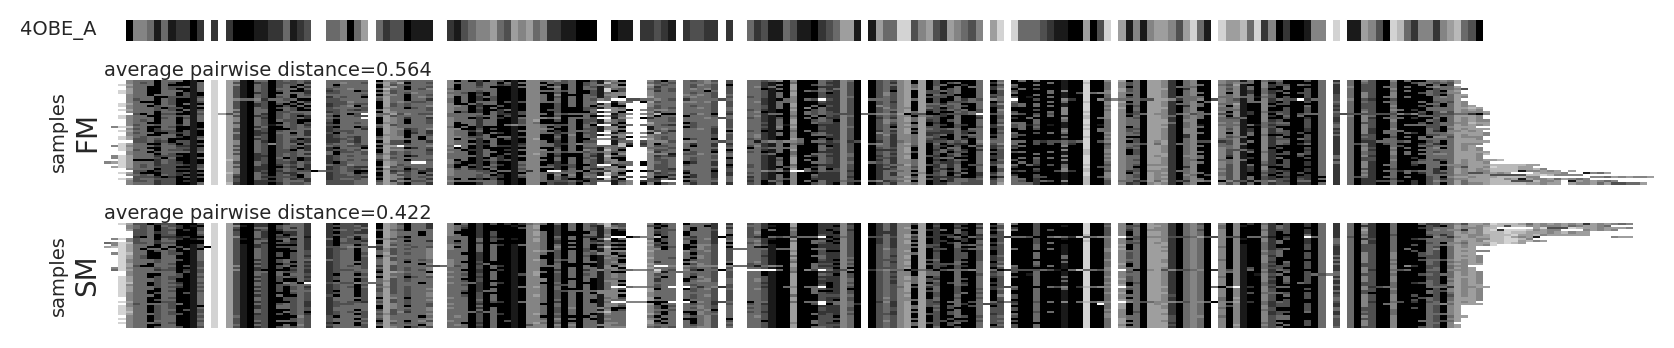

In [10]:
cmap = mcolors.ListedColormap([
    "#ffffff",  # gap
    "#D3D3D3", "#B9B9B9", "#9E9E9E", "#848484", "#6A6A6A", "#4F4F4F", "#353535", "#1A1A1A", "#000000"
    # "#ADD8E6", "#97BDDB", "#82A2CF", "#6C87C4", "#566CB8", "#4151AD", "#2B36A2", "#161B96", "#00008B"  # 1 <-> 9
    # "#0a7d82", "#44afbf", "#a5dce6", "#d7f0f0", "#ffffff", "#faebf5", "#fac8dc", "#f07daa", "#a0285f"  # 1 <-> 9
])
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, figsize=(10, 2), dpi=200, gridspec_kw={'height_ratios': [1, 5, 5]})
fig.subplots_adjust(hspace=0.5)
sns.heatmap(
    [rf_levels],
    cbar=False,
    cmap=cmap,
    norm=mcolors.BoundaryNorm(list(range(cmap.N + 1)), cmap.N),
    ax=ax1
)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.text(-0.005, 0.5, REF_PDB_ID, transform=ax1.transAxes, ha='right', va='center', fontsize=7)

sns.heatmap(
    fm_levels,
    cbar=False,
    cmap=cmap,
    norm=mcolors.BoundaryNorm(list(range(cmap.N + 1)), cmap.N),
    ax=ax2
)
ax2.set_xticks([])
ax2.set_yticks([])
ax2.tick_params(axis='x', pad=0)
ax2.set_ylabel("samples", labelpad=13, fontsize=7)
ax2.text(-0.02, 0.5, 'FM', transform=ax2.transAxes, ha='left', va='center', rotation=90)

sns.heatmap(
    sm_levels,
    cbar=False,
    cmap=cmap,
    norm=mcolors.BoundaryNorm(list(range(cmap.N + 1)), cmap.N),
    ax=ax3
)
ax3.set_xticks([])
ax3.set_yticks([])
ax3.tick_params(axis='x', pad=0)
ax3.set_ylabel("samples", labelpad=13, fontsize=7)
ax3.text(-0.02, 0.5, 'SM', transform=ax3.transAxes, ha='left', va='center', rotation=90)

sm_score = 0
fm_score = 0
for record in SeqIO.parse(ALN_FASTA, "fasta"):
    consurf = pd.read_csv(WD / f"C/{record.id}_consurf_grades.csv")
    if record.id.startswith("FM"):
        fm_score += np.sum(consurf["SCORE"])
    elif record.id.startswith("SM"):
        sm_score += np.sum(consurf["SCORE"])
        
ax2.text(0, 1,
         # f'conservation score={fm_score:.3f}   average pairwise distance={average_pairwise_distance(FM_DISTMAT):.3f}',
         f'average pairwise distance={average_pairwise_distance(FM_DISTMAT):.3f}',
         transform=ax2.transAxes, ha='left', va='bottom', fontsize=7)
ax3.text(0, 1, 
         f'average pairwise distance={average_pairwise_distance(SM_DISTMAT):.3f}', 
         # f'conservation score={sm_score:.3f}   average pairwise distance={average_pairwise_distance(SM_DISTMAT):.3f}', 
         transform=ax3.transAxes, ha='left', va='bottom', fontsize=7)

plt.show()

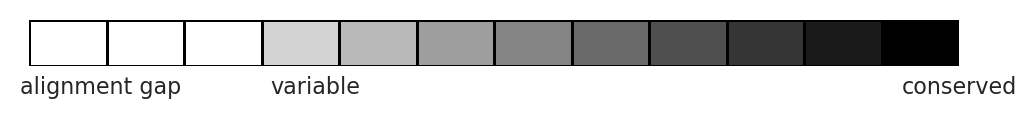

In [21]:
cmap = mcolors.ListedColormap([
    "#ffffff",  # gap
    "#ffffff", "#ffffff",  # use for margin
    "#D3D3D3", "#B9B9B9", "#9E9E9E", "#848484", "#6A6A6A", "#4F4F4F", "#353535", "#1A1A1A", "#000000"
])
fig, ax = plt.subplots(figsize=(6, 0.5), dpi=200)
cbar = fig.colorbar(plt.cm.ScalarMappable(cmap=cmap), ax=ax, orientation="horizontal", fraction=2, pad=0)
cbar.set_ticks(np.linspace(0, 1, 14))
cbar.set_ticklabels(["", "alignment gap", "", "", "variable", "", "", "", "", "", "", "", "", "conserved"])
cbar.ax.tick_params(labelsize=8)
cbar.outline.set_visible(False)
cbar.ax.tick_params(length=0)

cbar.solids.set_edgecolor("black")
cbar.solids.set_linewidth(1)
cbar.outline.set_visible(False)
ax.axis("off")

plt.show()